# Introduction

We have gathered daily price data for the Iranian Gold Coin along with its corresponding option data. This data has been partially cleaned, with some features added and others dropped.

The objective of this notebook is to:

1. Prepare the price data and apply various machine learning, deep learning, and statistical models to forecast the price for future intervals.

2. Design a trading strategy by using the forecasts from best methods of first part and estimate the performance of it.

## Two Approaches

There are at least two different approach for quantitative option trading.

1. Using ML, DL and Statistical models for forecasting the price and based on it, directly trading the options. This approach will be investigated in this notebook.

2. Using mentioned methods for estimating parameters of Stochastic Calculus models like volatility.\
As we provide another python file in this repository named "StochasticCalculusModeling.py", this approach is the subject of the next notebook.

### Notes

0. Most of the following model has been not tuned, so their performances can be much more better.

1. This notebook is a work in progress and will require further development in the future.

2. Real option pricing and analysis require additional data from other correlated assets and derivatives to ensure reliability.

3. Real option pricing and analysis necessitate more rigorous methods, potentially including tuned models and customized stochastic differential equations beyond standard approaches.

4. Interpretation of models and results is a critical aspect that remains incomplete in this work.

5. More historical and trading data is needed to enhance the robustness and reliability of our results.

# Data Preparation

In [1]:

import math
import talib
import random 
import optuna
import statistics
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from verstack import LGBMTuner


import seaborn as sns
from sklearn.svm import SVR
from numpy.random import seed
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from sklearn.linear_model import ElasticNet,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,accuracy_score
from pandas import to_datetime

from prophet import Prophet

from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    AutoCES,
    AutoETS,
    AutoRegressive,
    AutoTheta,
    SimpleExponentialSmoothing,
    SimpleExponentialSmoothingOptimized,
    SeasonalExponentialSmoothing,
    SeasonalExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
    RandomWalkWithDrift,
    ADIDA,
    CrostonClassic,
    CrostonOptimized,
    CrostonSBA,
    IMAPA,
    TSB,
    MSTL,
    TBATS,
    AutoTBATS,
    Theta,
    OptimizedTheta,
    DynamicTheta,
    DynamicOptimizedTheta,SeasonalNaive 
)

from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences


import jdatetime
from datetime import datetime,timedelta
from StochasticCalculusModeling import *
import pytorch_lightning as pl
from neuralforecast import NeuralForecast
from neuralforecast.models import RNN,LSTM,GRU,MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss

import warnings
warnings.filterwarnings('ignore')

In [2]:
GoldCoinPrice = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinPrice.csv")
GoldCoinPrice.index = GoldCoinPrice['Date']
GoldCoinPrice = GoldCoinPrice.drop(['Change', 'ChangePercent'], axis=1)
GoldCoinPrice.head()

,Date,Open,Low,High,Close
Date,,,,,
1397/01/14,1397/01/14,17310000,17290000,17460000,17360000
1397/01/15,1397/01/15,17390000,17390000,17490000,17490000
1397/01/16,1397/01/16,17390000,17390000,17390000,17390000
1397/01/17,1397/01/17,17560000,17550000,17910000,17830000
1397/01/18,1397/01/18,18050000,18050000,19560000,19300000


In [3]:
GoldCoinOptions = pd.read_csv(r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Option Pricing\GoldCoinOptions.csv")
GoldCoinOptions.head()

,حجم,ارزش(ریال),بالاترین(ریال),پایین ترین(ریال),آخرین(ریال),اولین(ریال),موقعیتهای باز,درصد تغییر,تعداد مشتریان فعال,تعداد کارگزاران فعال,...,قیمت تسویه (ریال),درصد تغییر قیمت تسویه,تاریخ,تاریخ اعمال,#!ارزش معاملات مشتریان حقیقی(خرید)(ریال),#!ارزش معاملات مشتریان حقیقی(فروش)(ریال),ContractType,StrikePrice,Profitability,ContractDurationDays
0,0,0,0,0,0,0,39,0,21,7,...,4900000,0.00,1398/01/15,1398/02/16,0,0,C,46000000,1,32
1,11,54040000,5500000,4700000,4890000,5500000,40,0,22,10,...,4912727,18.12,1398/01/15,1398/02/16,54040000,54040000,C,44000000,1,32
2,14,34763400,2899400,2300000,2300400,2899400,352,-6,51,11,...,2483100,8.62,1398/01/15,1398/02/16,34763400,34763400,C,48000000,1,32
3,0,0,0,0,0,0,17,0,13,4,...,1145568,0.00,1398/01/15,1398/02/16,0,0,P,44000000,0,32
4,0,0,0,0,0,0,5,0,5,3,...,1573415,8.38,1398/01/15,1398/02/16,0,0,P,46000000,0,32


## Add Some Features
This section includes 8 funtions for Data Preparation:

1. Add_Lag: Add arbitrary numbers of lags of data columns.

2. Indicator: Add all possible technical analysis features to the data using "Talib" library.

3. add_diff: Add price differences of consecutive days.

4. Roll_Stats: Add simple statistics of columns like mean, standard deviation, maximum ad minimum.

5. Prepare_Data: Combine above functions and implement them on the data.

6. Combine: Consider the Label and according to it, then Prepare Data for each columns and at th end, concat or merge them together.

7. mutual_information: Due to the large number of created columns, it's better to select most related and important of them. Therefore, we calculate their mutual information score with the target column and by setting an arbitrary value like mic=3, we drop all columns which their MIC scores with the target is smaller than 3.

8. Final_Data_Preparation: The last function that all above functions will run in it. This function prepare the dataset and drop uncorrelated features and return the final clean data.

### Note
In the first version of this notebook, we assume the GoldCoinPrice data as a univariate time series with 'Close' feature.

In [4]:
def Add_Lag(data,col,lag_list):

    position = data.columns.tolist().index(col)
    
    for lag in lag_list:
    
        col_val = data[col].shift(lag)

        col_name = col+'_lag:'+'{length}'.format(length=lag)

        data.insert(loc=position, column=col_name, value=col_val)
        

    return data

def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns

    position = data.columns.tolist().index(col)

    SimpleDiff = [0,0]
    LogDiff = [0,0]
    simpleReturn = [0,0]
    LogReturn = [0,0]

    for i in range(1,data.shape[0]-1):

        NaturalDifference = data[col][i] -  data[col][i-1]
        NaturalReturn = NaturalDifference / data[col][i-1]

        LogDiference = np.log(data[col][i]) - np.log(data[col][i-1])
        LogReturn_ = LogDiference / np.log(data[col][i-1])


        SimpleDiff.append(NaturalDifference)
        LogDiff.append(LogDiference)
        simpleReturn.append(NaturalReturn)
        LogReturn.append(LogReturn_)

    
    data.insert(loc=position, column=col+'_SimpleDifference', value=SimpleDiff)
    data.insert(loc=position, column=col+'_LogDifference', value=LogDiff)
    data.insert(loc=position, column=col+'_simpleReturn', value=simpleReturn)
    data.insert(loc=position, column=col+'_ LogReturn', value=LogReturn)

    return data

def Roll_Stats(data,col,Roll_Window): #Calculating simple statistics of the data
    
    lag = 1

    position = data.columns.tolist().index(col)
    
    for window in Roll_Window:
        
        Window = window
        col_val = data[col].shift(lag)
        window = col_val.rolling(window=window)
        means = window.mean()
        std = window.var()
        Max  = window.max()
        Min = window.min()
    
        col_name_mean = col+'_mean'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_std = col+'_std'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)


        data.insert(loc=position, column=col_name_mean, value=means)
        data.insert(loc=position, column=col_name_std, value=std)
        data.insert(loc=position, column=col_name_max, value=Max)
        data.insert(loc=position, column=col_name_min, value=Min)

    return data

def Add_Indicators(Data, data, col):
    target = data['Close']
    data = data.drop(['Close'],axis=1)
    # RSI period (default is 14)
    rsi = talib.RSI(data[col].values, timeperiod=14)

    macd, macd_signal, _ = talib.MACD(data[col].values)
    slowk, slowd = talib.STOCH(high=Data['High'].shift(1).values, low=Data['Low'].shift(1).values, close=data[col].values)
    upper_band, middle_band, lower_band = talib.BBANDS(data[col].values)
    sma = talib.SMA(data[col].values)

    # Add indicators to the DataFrame
    data['MACD'] = macd
    data['MACD_signal'] = macd_signal
    data['RSI'] = rsi
    data['Stochastic_SlowK'] = slowk
    data['Stochastic_SlowD'] = slowd
    data['BBands_upper'] = upper_band
    data['BBands_middle'] = middle_band
    data['BBands_lower'] = lower_band
    data['SMA'] = sma
    data['Close'] = target

    return data



def FeatureExtractor(data,lag_list,window_list):

    data = Add_Lag(data, 'Close',lag_list)
    data = add_diff(data, 'Close')
    data = Roll_Stats(data,'Close', window_list)
    data = Add_Indicators(GoldCoinPrice,data,'Close_lag:1')
    data = data.dropna()
    return data

In [5]:
data = pd.DataFrame(GoldCoinPrice['Close'])
Added_data = FeatureExtractor(data,[i for i in range(1,30)],[i for i in range(2,30)])
Added_data

,Close_lag:29,Close_lag:28,Close_lag:27,Close_lag:26,Close_lag:25,Close_lag:24,Close_lag:23,Close_lag:22,Close_lag:21,Close_lag:20,...,MACD,MACD_signal,RSI,Stochastic_SlowK,Stochastic_SlowD,BBands_upper,BBands_middle,BBands_lower,SMA,Close
Date,,,,,,,,,,,,,,,,,,,,,
1397/02/18,19550000.0,17700000.0,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,...,4.790696e+05,2.762043e+05,62.153563,39.765589,54.053632,2.098541e+07,19901000.0,1.881659e+07,1.854417e+07,20190000
1397/02/19,17700000.0,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,...,5.160334e+05,3.241701e+05,63.237778,38.934426,42.068773,2.108001e+07,20007000.0,1.893399e+07,1.857383e+07,21030000
1397/02/20,17910000.0,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,...,6.061214e+05,3.805604e+05,68.100595,69.314769,49.338261,2.144618e+07,20118000.0,1.878982e+07,1.862317e+07,21060000
1397/02/21,17850000.0,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,18200000.0,...,6.721890e+05,4.388861e+05,68.262065,85.708211,64.652469,2.178798e+07,20256000.0,1.872402e+07,1.873517e+07,20580000
1397/02/22,17850000.0,17810000.0,18560000.0,17970000.0,18400000.0,18290000.0,18290000.0,18350000.0,18200000.0,17700000.0,...,6.780005e+05,4.867090e+05,62.785909,88.543294,81.188758,2.142383e+07,20576000.0,1.972817e+07,1.882417e+07,19790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403/01/16,328510000.0,329360000.0,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,...,1.883806e+07,1.490013e+07,91.127945,70.462110,44.725775,4.480069e+08,404914000.0,3.618211e+08,3.660283e+08,458080000
1403/01/18,329360000.0,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,368070000.0,...,2.245962e+07,1.641203e+07,92.893358,98.056253,69.206074,4.745861e+08,418974000.0,3.633619e+08,3.702653e+08,448060000
1403/01/19,332880000.0,334540000.0,335540000.0,342100000.0,337490000.0,340090000.0,345050000.0,344580000.0,368070000.0,370850000.0,...,2.424176e+07,1.797798e+07,83.549676,91.765930,86.761431,4.801435e+08,431020000.0,3.818965e+08,3.742503e+08,419970000


## RFECV
After naively adding features, we need to drop bad ones. there are lots of methods for doing that, here we choose the rigorous and automatic method which named RFECV.

Selected Features: [  0   4  12  13  15  18  19  26  30  31  32 145 146 147 148 149 153]


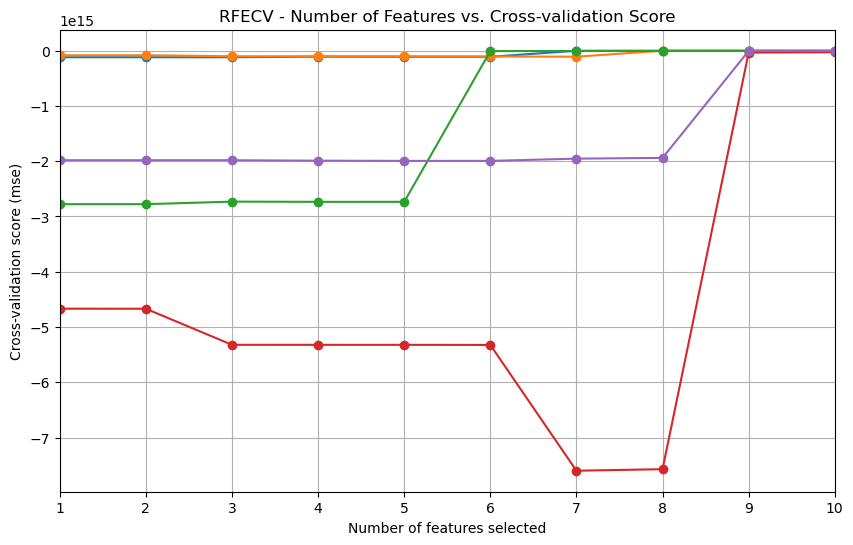

In [6]:
train_x, train_y = Added_data.values[:1100,:-1], Added_data.values[:1100,-1]
val_x, val_y = Added_data.values[1100:1500,:-1], Added_data.values[1100:1500,-1]
test_x, test_y = Added_data.values[1500:,:-1], Added_data.values[1500:,-1]

# Create a random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)
EN = ElasticNet(alpha=0.1,l1_ratio=0.9)
tscv = TimeSeriesSplit(n_splits=5)
# Create the RFECV object
rfecv = RFECV(estimator=EN, step=1, cv=tscv, scoring='neg_mean_squared_error', min_features_to_select=1,n_jobs=-1)

# Fit the RFECV
rfecv.fit(train_x, train_y)

# Get the selected features
selected_features = np.where(rfecv.support_ == True)[0]

# Print the selected features
print("Selected Features:", selected_features)

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (mse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, marker='o', linestyle='-')
plt.xlim(1, 10)  # Limit x-axis to 10 features
plt.xticks(range(1, 11))
plt.grid(True)
plt.title('RFECV - Number of Features vs. Cross-validation Score')
plt.show()

In [10]:
selected_feature_names = Added_data.columns[[0, 4, 12, 13, 15, 18, 19, 26,28, 30, 31, 32, 145, 146, 147, 148, 149, 153,154]]

Added_data = Added_data[selected_feature_names]
Added_data

,Close_lag:29,Close_lag:25,Close_lag:17,Close_lag:16,Close_lag:14,Close_lag:11,Close_lag:10,Close_lag:3,Close_lag:1,Close_simpleReturn,Close_LogDifference,Close_SimpleDifference,MACD,MACD_signal,RSI,Stochastic_SlowK,Stochastic_SlowD,SMA,Close
Date,,,,,,,,,,,,,,,,,,,
1397/02/18,19550000.0,17850000.0,18200000.0,17700000.0,17470000.0,18000000.0,18450000.0,20370000.0,20020000.0,0.054795,0.053346,1040000,4.790696e+05,2.762043e+05,62.153563,39.765589,54.053632,1.854417e+07,20190000
1397/02/19,17700000.0,17810000.0,17700000.0,17600000.0,17670000.0,18450000.0,18550000.0,18980000.0,20190000.0,0.008492,0.008456,170000,5.160334e+05,3.241701e+05,63.237778,38.934426,42.068773,1.857383e+07,21030000
1397/02/20,17910000.0,18560000.0,17600000.0,17470000.0,17670000.0,18550000.0,19000000.0,20020000.0,21030000.0,0.041605,0.040763,840000,6.061214e+05,3.805604e+05,68.100595,69.314769,49.338261,1.862317e+07,21060000
1397/02/21,17850000.0,17970000.0,17470000.0,17670000.0,18000000.0,19000000.0,19080000.0,20190000.0,21060000.0,0.001427,0.001426,30000,6.721890e+05,4.388861e+05,68.262065,85.708211,64.652469,1.873517e+07,20580000
1397/02/22,17850000.0,18400000.0,17670000.0,17670000.0,18450000.0,19080000.0,19600000.0,21030000.0,20580000.0,-0.022792,-0.023056,-480000,6.780005e+05,4.867090e+05,62.785909,88.543294,81.188758,1.882417e+07,19790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403/01/16,328510000.0,335540000.0,372540000.0,362880000.0,366850000.0,376920000.0,380820000.0,387980000.0,438880000.0,0.039754,0.038984,16780000,1.883806e+07,1.490013e+07,91.127945,70.462110,44.725775,3.660283e+08,458080000
1403/01/18,329360000.0,342100000.0,362880000.0,366580000.0,367010000.0,380820000.0,388060000.0,422100000.0,458080000.0,0.043748,0.042818,19200000,2.245962e+07,1.641203e+07,92.893358,98.056253,69.206074,3.702653e+08,448060000
1403/01/19,332880000.0,337490000.0,366580000.0,366850000.0,371050000.0,388060000.0,387930000.0,438880000.0,448060000.0,-0.021874,-0.022117,-10020000,2.424176e+07,1.797798e+07,83.549676,91.765930,86.761431,3.742503e+08,419970000


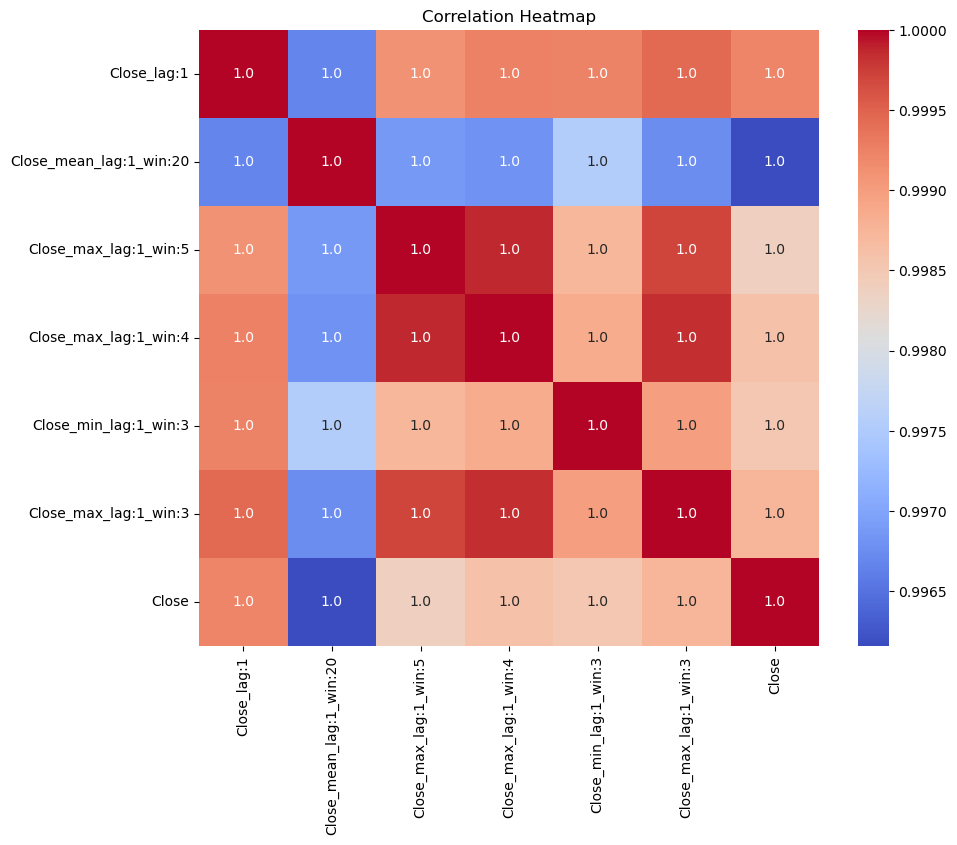

In [110]:
corr_matrix = Added_data.corr()
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

In [35]:
# Calculate mutual information
mi_values = []
for column in Added_data.columns[:-1]:
    mi = mutual_info_regression(Added_data[[column]], Added_data['Close'])
    mi_values.append(mi[0])

# Calculate correlation with 'Close'
corr_values = Added_data.corr()['Close'].values

# Create the mutual information table
mi_df = pd.DataFrame({'Feature': Added_data.columns[:-1], 'Mutual_Information': mi_values, 'Correlation_with_Close': corr_values[:-1]})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)

mi_df

,Feature,Mutual_Information,Correlation_with_Close
0,Close_lag:1,3.296385,0.999226
1,Close_mean_lag:1_win:2,3.170984,0.999025
2,Close_max_lag:1_win:2,3.165788,0.998911
3,Close_min_lag:1_win:2,3.137546,0.998890
4,Close_max_lag:1_win:3,3.104040,0.998731
...,...,...,...
224,Stochastic_SlowK,0.084417,-0.045495
225,Close_SimpleDifference,0.072824,0.073251
226,Close_LogDifference,0.060943,0.012846
227,Close_simpleReturn,0.060773,0.012323


We can surely continue work on the data. for example we should make the data stationary 

# Forecasting Gold Coin Price

## Machine Learning Models

In [11]:
train_x, train_y = Added_data.values[:1200,:-1], Added_data.values[:1200,-1]
val_x, val_y = Added_data.values[1200:1700,:-1], Added_data.values[1200:1700,-1]
test_x, test_y = Added_data.values[1700:,:-1], Added_data.values[1700:,-1]

### 0. Base Model

To evaluate the performance of the models we will work on, it is better to have a base model, which its prediction is the lag 1 of the target e.g. $\hat{y}(t) = y(t-1) $.

In [12]:
def BaseModel(train_y, val_y):

    BasePrediction = [train_y[-1]]

    for i in range(len(val_y)-1):

        BasePrediction.append(val_y[i])
    
    return BasePrediction
     
BasePrediction = BaseModel(train_y, val_y)
# Calculate accuracy metrics
mae = mean_absolute_error(val_y, BasePrediction)
mse = mean_squared_error(val_y, BasePrediction)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, BasePrediction)


print("Mean Absolute Error (MSE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=BasePrediction, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='Base Model vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

Mean Absolute Error (MSE): 2678994.0
Mean Squared Error (MSE): 27307386837040.0
Root Mean Squared Error (RMSE): 5225647.025683996
R-squared (R2): 0.9946049181592032


### 1. ElasticNet

In [26]:
# Scale the input data
scaler_x = StandardScaler()
train_x_scaled = scaler_x.fit_transform(train_x)
val_x_scaled = scaler_x.transform(val_x)

scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1)).ravel()

def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 0.1)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.5, 1)
    max_iter = trial.suggest_int('max_iter', 1000, 10000)

    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    elastic_net.fit(train_x_scaled, train_y_scaled)
    
    val_predictions_scaled = elastic_net.predict(val_x_scaled)
    val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()
    
    mse = mean_squared_error(val_y, val_predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']
best_max_iter = study.best_params['max_iter']

# Train the model with the best hyperparameters
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=best_max_iter)
elastic_net.fit(train_x_scaled, train_y_scaled)

val_predictions_scaled = elastic_net.predict(val_x_scaled)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled.reshape(-1, 1)).ravel()

# Calculate accuracy metrics
mae = mean_absolute_error(val_y, val_predictions)
mse = mean_squared_error(val_y, val_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(val_y, val_predictions)

print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)
print("Best max_iter:", best_max_iter)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_predictions, mode='lines', name='Predicted', line=dict(dash='dash')))
fig.update_layout(title='ElasticNet vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

[I 2024-04-13 09:51:25,441] A new study created in memory with name: no-name-c98f9720-ee35-43ac-bb87-14477fa2b278
[I 2024-04-13 09:51:25,449] Trial 0 finished with value: 164344425994390.22 and parameters: {'alpha': 0.08949359438512165, 'l1_ratio': 0.5839652372450537, 'max_iter': 4260}. Best is trial 0 with value: 164344425994390.22.
[I 2024-04-13 09:51:25,465] Trial 1 finished with value: 28219857021829.78 and parameters: {'alpha': 0.005668305524048134, 'l1_ratio': 0.9197387189936628, 'max_iter': 2790}. Best is trial 1 with value: 28219857021829.78.
[I 2024-04-13 09:51:25,486] Trial 2 finished with value: 34568431942420.31 and parameters: {'alpha': 0.012288927930951411, 'l1_ratio': 0.562197270900525, 'max_iter': 2524}. Best is trial 1 with value: 28219857021829.78.
[I 2024-04-13 09:51:25,497] Trial 3 finished with value: 103042852140204.75 and parameters: {'alpha': 0.06115041611889005, 'l1_ratio': 0.5821393882731998, 'max_iter': 1491}. Best is trial 1 with value: 28219857021829.78.
[I

Best alpha: 0.00044711987778302584
Best l1_ratio: 0.9474013061265621
Best max_iter: 4001
Mean Absolute Error (MAE): 2699594.9242582954
Mean Squared Error (MSE): 26740118253862.4
Root Mean Squared Error (RMSE): 5171084.82369632
R-squared (R2): 0.9947169926118127


### 2. Prophet

In [7]:
prophet_data = pd.DataFrame(columns = ['ds', 'y'])
prophet_data['ds'] = Added_data.index
prophet_data['y'] = Added_data['Close'].values
prophet_data

,ds,y
0,1397/02/18,20190000
1,1397/02/19,21030000
2,1397/02/20,21060000
3,1397/02/21,20580000
4,1397/02/22,19790000
...,...,...
1881,1403/01/16,458080000
1882,1403/01/18,448060000
1883,1403/01/19,419970000
1884,1403/01/20,415800000


In [8]:
# Assuming 'ds' is the column with the date
prophet_data['ds'] = prophet_data['ds'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

print(prophet_data)

             ds          y
0    2018-05-08   20190000
1    2018-05-09   21030000
2    2018-05-10   21060000
3    2018-05-11   20580000
4    2018-05-12   19790000
...         ...        ...
1881 2024-04-04  458080000
1882 2024-04-06  448060000
1883 2024-04-07  419970000
1884 2024-04-08  415800000
1885 2024-04-09  437060000

[1886 rows x 2 columns]


In [37]:
# Initialize Prophet model
model = Prophet()
prophet_data
# Fit the model
model.fit(prophet_data.iloc[:1200, :])

# Make future predictions
future = model.make_future_dataframe(periods=500)  # Forecasting for the next 30 days
forecast = model.predict(future)
forecast

18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-05-08,2.296017e+07,1.335670e+07,2.527120e+07,2.296017e+07,2.296017e+07,-3.245739e+06,-3.245739e+06,-3.245739e+06,172639.485803,172639.485803,172639.485803,-3.418378e+06,-3.418378e+06,-3.418378e+06,0.0,0.0,0.0,1.971443e+07
1,2018-05-09,2.307670e+07,1.348745e+07,2.552497e+07,2.307670e+07,2.307670e+07,-3.298608e+06,-3.298608e+06,-3.298608e+06,-10425.934068,-10425.934068,-10425.934068,-3.288182e+06,-3.288182e+06,-3.288182e+06,0.0,0.0,0.0,1.977810e+07
2,2018-05-10,2.319324e+07,1.411278e+07,2.581168e+07,2.319324e+07,2.319324e+07,-3.329330e+06,-3.329330e+06,-3.329330e+06,-171936.236318,-171936.236318,-171936.236318,-3.157394e+06,-3.157394e+06,-3.157394e+06,0.0,0.0,0.0,1.986391e+07
3,2018-05-11,2.330977e+07,1.437788e+07,2.614379e+07,2.330977e+07,2.330977e+07,-3.293618e+06,-3.293618e+06,-3.293618e+06,-264515.307449,-264515.307449,-264515.307449,-3.029103e+06,-3.029103e+06,-3.029103e+06,0.0,0.0,0.0,2.001615e+07
4,2018-05-12,2.342630e+07,1.427629e+07,2.612412e+07,2.342630e+07,2.342630e+07,-2.960925e+06,-2.960925e+06,-2.960925e+06,-54717.191981,-54717.191981,-54717.191981,-2.906208e+06,-2.906208e+06,-2.906208e+06,0.0,0.0,0.0,2.046537e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,2023-06-18,1.864623e+08,8.438693e+07,2.751963e+08,8.791012e+07,2.784457e+08,-2.231231e+06,-2.231231e+06,-2.231231e+06,168105.574311,168105.574311,168105.574311,-2.399337e+06,-2.399337e+06,-2.399337e+06,0.0,0.0,0.0,1.842311e+08
1696,2023-06-19,1.865729e+08,8.427705e+07,2.776838e+08,8.774407e+07,2.787927e+08,-2.090675e+06,-2.090675e+06,-2.090675e+06,160849.609701,160849.609701,160849.609701,-2.251524e+06,-2.251524e+06,-2.251524e+06,0.0,0.0,0.0,1.844822e+08
1697,2023-06-20,1.866834e+08,8.523792e+07,2.794172e+08,8.755216e+07,2.791355e+08,-1.925035e+06,-1.925035e+06,-1.925035e+06,172639.485803,172639.485803,172639.485803,-2.097675e+06,-2.097675e+06,-2.097675e+06,0.0,0.0,0.0,1.847583e+08
1698,2023-06-21,1.867939e+08,8.553308e+07,2.773481e+08,8.735233e+07,2.794783e+08,-1.949656e+06,-1.949656e+06,-1.949656e+06,-10425.934068,-10425.934068,-10425.934068,-1.939230e+06,-1.939230e+06,-1.939230e+06,0.0,0.0,0.0,1.848443e+08


In [43]:
# Plot the predictions against the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=val_y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend_upper'].values[1200:1700], mode='lines', name='trend_upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend_lower'].values[1200:1700], mode='lines', name='trend_lower', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['yhat_upper'].values[1200:1700], mode='lines', name='yhat_upper', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecast['trend'].values[1200:1700], mode='lines', name='trend', line=dict(dash='dash')))

fig.update_layout(title='Prophet vs Actual', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

### 3. MLForecast

In [33]:
Close = pd.DataFrame(columns = ['unique_id','ds','y'])
Close['unique_id'] = ['Close' for i in range(GoldCoinPrice.shape[0])]
Close['ds'] = GoldCoinPrice['Date'].values
Close['y'] = GoldCoinPrice['Close'].values

Close['ds'] = Close['ds'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
Close['ds'] = pd.to_datetime(Close['ds'])
Close

,unique_id,ds,y
0,Close,2018-04-03,17360000
1,Close,2018-04-04,17490000
2,Close,2018-04-05,17390000
3,Close,2018-04-06,17830000
4,Close,2018-04-07,19300000
...,...,...,...
1915,Close,2024-04-04,458080000
1916,Close,2024-04-06,448060000
1917,Close,2024-04-07,419970000
1918,Close,2024-04-08,415800000


In [63]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    ElasticNet(), RandomForestRegressor()
]

MLResults = {'LGBMRegressor':[], 'ElasticNet':[], 'RandomForestRegressor':[]}

for i in range(0,540,30):
    Y_train_df = Close.iloc[:1200+i,:]
    fcst = MLForecast(
        models=models,
        freq='D',
        lags=[i for i in range(1,10)],
        lag_transforms={
            1: [ExpandingMean()],
            7: [RollingMean(window_size=28)]
        },
        date_features=['dayofweek'],
        target_transforms=[Differences([1])],
    )
    fcst.fit(Y_train_df)
    predictions = fcst.predict(30)

    for model in predictions.columns[2:]:

        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], predictions[model].values)
        MLResults[model].append(mae)

for model in predictions.columns[2:]:

    MLResults[model] = np.mean(MLResults[model])

Sorted_MLResults = dict(sorted(MLResults.items(), key=lambda x: x[1]))
Sorted_MLResults


{'ElasticNet': 10444210.207407406,
 'LGBMRegressor': 11569425.674074074,
 'RandomForestRegressor': 13087547.585185185}

# Deep Learning Models

### 1. RNN

In [ ]:
RNNResult = {'RNN-median':[] ,	'RNN-lo-90':[] ,'RNN-lo-80':[],	'RNN-hi-80':[] , 'RNN-hi-90':[]}
for i in range(0,540,30):
    Y_train_df = Close.iloc[:1200+i,:]
    Y_test_df = Close.iloc[1200+i:1230+i,:]
    fcst = NeuralForecast(
        models=[RNN(h=30,
                    input_size=-1,
                    inference_input_size=24,
                    loss=MQLoss(level=[80,90]),
                    scaler_type='robust',
                    encoder_n_layers=3,
                    encoder_hidden_size=128,
                    context_size=10,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=300)
        ],
        freq='D'
    )
    fcst.fit(df=Y_train_df, val_size=30,verbose=True)

    # Create future dataframe with expected combinations of IDs and times
    futr_df = fcst.make_future_dataframe(df=Y_train_df)

    forecasts = fcst.predict(futr_df=futr_df)
    for model in forecasts.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts[model].values)
        RNNResult[model].append(mae)

for model in forecasts.columns[1:]:

    RNNResult[model] = np.mean(RNNResult[model])

RNNResult

In [34]:
RNNResult = {'RNN-median': 22560902.08888889,
 'RNN-lo-90': 35587978.607407406,
 'RNN-lo-80': 27775803.200000003,
 'RNN-hi-80': 26773236.2962963,
 'RNN-hi-90': 29435922.77037037}

### 2. LSTM

In [ ]:
LSTMResult = {'LSTM-median':[] ,'LSTM-lo-90':[] ,'LSTM-lo-80':[],'LSTM-hi-80':[] , 'LSTM-hi-90':[]}
for i in range(0,540,30):
    Y_train_df = Close.iloc[:1200+i,:]
    Y_test_df = Close.iloc[1200+i:1230+i,:]
    fcst = NeuralForecast(
        models=[LSTM(h=30,
                    input_size=-1,
                    inference_input_size=24,
                    loss=MQLoss(level=[80,90]),
                    scaler_type='robust',
                    encoder_n_layers=3,
                    encoder_hidden_size=128,
                    context_size=10,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=300)
        ],
        freq='D'
    )
    fcst.fit(df=Y_train_df, val_size=30,verbose=True)

    # Create future dataframe with expected combinations of IDs and times
    futr_df = fcst.make_future_dataframe(df=Y_train_df)

    forecasts = fcst.predict(futr_df=futr_df)
    for model in forecasts.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts[model].values)
        LSTMResult[model].append(mae)

for model in forecasts.columns[1:]:

    LSTMResult[model] = np.mean(LSTMResult[model])

LSTMResult

In [35]:
LSTMResult = {'LSTM-median': 58924752.651851855,
 'LSTM-lo-90': 82630950.07037038,
 'LSTM-lo-80': 70787409.17777778,
 'LSTM-hi-80': 45198406.68148148,
 'LSTM-hi-90': 43413003.007407404}

### 3. GRU

In [ ]:
GRUResult = {'GRU-median':[] ,'GRU-lo-90':[] ,'GRU-lo-80':[],'GRU-hi-80':[] , 'GRU-hi-90':[]}
for i in range(0,540,30):
    Y_train_df = Close.iloc[:1200+i,:]
    Y_test_df = Close.iloc[1200+i:1230+i,:]
    fcst = NeuralForecast(
        models=[GRU(h=30,
                    input_size=-1,
                    inference_input_size=24,
                    loss=MQLoss(level=[80,90]),
                    scaler_type='robust',
                    encoder_n_layers=3,
                    encoder_hidden_size=128,
                    context_size=10,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=300)
        ],
        freq='D'
    )
    fcst.fit(df=Y_train_df, val_size=30,verbose=True)

    # Create future dataframe with expected combinations of IDs and times
    futr_df = fcst.make_future_dataframe(df=Y_train_df)

    forecasts = fcst.predict(futr_df=futr_df)
    for model in forecasts.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts[model].values)
        GRUResult[model].append(mae)

for model in forecasts.columns[1:]:

    GRUResult[model] = np.mean(GRUResult[model])

GRUResult

In [36]:
GRUResult = {'GRU-median': 36024912.844444446,
 'GRU-lo-90': 42595774.162962966,
 'GRU-lo-80': 40181061.64444444,
 'GRU-hi-80': 38829212.34074074,
 'GRU-hi-90': 40838592.26666667}

### 4. MLP

In [ ]:
MLPResult = {'MLP-median':[] ,'MLP-lo-90':[] ,'MLP-lo-80':[],'MLP-hi-80':[] , 'MLP-hi-90':[]}
for i in range(0,540,30):
    Y_train_df = Close.iloc[:1200+i,:]
    Y_test_df = Close.iloc[1200+i:1230+i,:]
    fcst = NeuralForecast(
        models=[MLP(h=30,
                    input_size=2,
                    loss=MQLoss(level=[80,90]),
                    scaler_type='robust',
                    max_steps=300)
        ],
        freq='D'
    )
    fcst.fit(df=Y_train_df, val_size=30,verbose=True)

    # Create future dataframe with expected combinations of IDs and times
    futr_df = fcst.make_future_dataframe(df=Y_train_df)

    forecasts = fcst.predict(futr_df=futr_df)
    for model in forecasts.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts[model].values)
        MLPResult[model].append(mae)

for model in forecasts.columns[1:]:

    MLPResult[model] = np.mean(MLPResult[model])

MLPResult

In [37]:
MLPResult = {'MLP-median': 47236410.414814815,
 'MLP-lo-90': 108344135.91851851,
 'MLP-lo-80': 82994783.49629632,
 'MLP-hi-80': 123043836.79999998,
 'MLP-hi-90': 197898618.1037037}

### Deep Learning Models Results

In [38]:
#Merging all result to one dictionary and sort it to find the best model

DeepLearningModelsMeanError = {**MLPResult, **GRUResult, **LSTMResult, **RNNResult}

sorted_DeepLearningModelsMeanError = dict(sorted(DeepLearningModelsMeanError.items(), key=lambda x: x[1]))
sorted_DeepLearningModelsMeanError

{'RNN-median': 22560902.08888889,
 'RNN-hi-80': 26773236.2962963,
 'RNN-lo-80': 27775803.200000003,
 'RNN-hi-90': 29435922.77037037,
 'RNN-lo-90': 35587978.607407406,
 'GRU-median': 36024912.844444446,
 'GRU-hi-80': 38829212.34074074,
 'GRU-lo-80': 40181061.64444444,
 'GRU-hi-90': 40838592.26666667,
 'GRU-lo-90': 42595774.162962966,
 'LSTM-hi-90': 43413003.007407404,
 'LSTM-hi-80': 45198406.68148148,
 'MLP-median': 47236410.414814815,
 'LSTM-median': 58924752.651851855,
 'LSTM-lo-80': 70787409.17777778,
 'LSTM-lo-90': 82630950.07037038,
 'MLP-lo-80': 82994783.49629632,
 'MLP-lo-90': 108344135.91851851,
 'MLP-hi-80': 123043836.79999998,
 'MLP-hi-90': 197898618.1037037}

# Statistical Models

Here we use statsforecast library for making forecast with multiple statistical models.\
"StatsForecast offers a collection of widely used univariate time series forecasting models, including automatic ARIMA, ETS, CES, and Theta modeling optimized for high performance using numba. It also includes a large battery of benchmarking models."

In [39]:
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=24), AutoCES(), AutoETS(),AutoTheta(),
     SimpleExponentialSmoothing(alpha=0.5), SimpleExponentialSmoothingOptimized(),
    SeasonalExponentialSmoothing(alpha=0.5,season_length=24),SeasonalExponentialSmoothingOptimized(season_length=24),
    Holt(),HoltWinters(),RandomWalkWithDrift(),ADIDA(),CrostonClassic(),
    CrostonOptimized(),CrostonSBA(),IMAPA(),TSB(alpha_d=0.5,alpha_p = 0.5),MSTL(season_length=24),TBATS(season_length=24),AutoTBATS(season_length=24),
    Theta(),OptimizedTheta(), DynamicTheta(), DynamicOptimizedTheta()
]
#, AutoRegressive(lags=[1,5,10,20,30])

sf = StatsForecast(
    df=Close.iloc[:1200,:], 
    models=models,
    freq='D', #freq='D' means daily frequency
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

""" 
h (int): represents the forecast h steps into the future. In this case, 12 months ahead.

level (list of floats): this optional parameter is used for probabilistic forecasting.
 Set the level (or confidence percentile) of your prediction interval.
   For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.
"""

forecasts_df = sf.forecast(h=30, level=[90])

forecasts_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,CES,CES-lo-90,CES-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,...,Theta-hi-90,OptimizedTheta,OptimizedTheta-lo-90,OptimizedTheta-hi-90,DynamicTheta,DynamicTheta-lo-90,DynamicTheta-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
Close,2022-01-04,128848200.0,125932336.0,131764056.0,129375496.0,126354096.0,132398608.0,129008512.0,124096208.0,133920816.0,...,132327304.0,129003608.0,126333192.0,132371840.0,128959064.0,126286920.0,132329488.0,128958600.0,126286472.0,132329000.0
Close,2022-01-05,128915536.0,124710480.0,133120600.0,129455888.0,126436640.0,132478704.0,129126824.0,122175672.0,136077968.0,...,133224552.0,129097576.0,125060984.0,133313176.0,129008928.0,124969736.0,133227280.0,129008000.0,124968840.0,133226320.0
Close,2022-01-06,129139112.0,124025136.0,134253088.0,129547360.0,126522968.0,132574248.0,129245128.0,120726424.0,137763840.0,...,134048200.0,129191544.0,123339368.0,134180904.0,129058776.0,123202872.0,134051416.0,129057392.0,123201496.0,134050032.0
Close,2022-01-07,129149888.0,123431352.0,134868432.0,129630064.0,126606000.0,132657584.0,129363440.0,119520648.0,139206240.0,...,134204112.0,129285512.0,123364360.0,134380912.0,129108616.0,123183792.0,134207424.0,129106768.0,123181968.0,134205536.0
Close,2022-01-08,129132912.0,122876840.0,135388992.0,129719896.0,126692136.0,132750656.0,129481752.0,118470168.0,140493328.0,...,135321728.0,129379480.0,123285072.0,135542576.0,129158440.0,123060344.0,135325728.0,129156128.0,123058056.0,135323376.0


In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=Close['y'].values[1200:1230], mode='lines', name='Actual'))
for col in forecasts_df.columns[1:]:

    fig.add_trace(go.Scatter(x=Added_data.index[1200:1230], y=forecasts_df[f'{col}'].values, mode='lines', name=col, line=dict(dash='dash')))
#fig.add_trace(go.Scatter(x=Added_data.index[1200:1700], y=forecasts_df['DynamicOptimizedTheta-hi-90'].values, mode='lines', name='trend', line=dict(dash='dash')))

fig.update_layout(title='Statistical Models Forecasting - 30 days', xaxis_title='Date', yaxis_title='Value', hovermode='x')
fig.show()

## Best Statistical Models
In this part we use different statistical models for forecasting the close price for periods of 30 days one after another.\
Then, we choose the best of them based on their mean MAE.

In [80]:
StatsModelsResult = {}

for model in forecasts_df.columns[1:]:
    StatsModelsResult[model] = []
    
for i in range(0,540,30):

    sf = StatsForecast(
        df=Close.iloc[:1200+i,:], 
        models=models,
        freq='D', #freq='D' means daily frequency
        n_jobs=-1,
        fallback_model = SeasonalNaive(season_length=7)
    )

    forecasts_df = sf.forecast(h=30, level=[90])
    for model in forecasts_df.columns[1:]:
        mae = mean_absolute_error(Close['y'].values[1200+i:1230+i], forecasts_df[model].values)
        StatsModelsResult[model].append(mae)

StatsModelMeanError = {}

for model in forecasts_df.columns[1:]:
    StatsModelMeanError[model] = 0
    
for model in forecasts_df.columns[1:]:

    StatsModelMeanError[model] = np.mean(StatsModelsResult[model])

#sort the models in dictionary based on their Error (Ascending)
    
sorted_StatsModelMeanError = dict(sorted(StatsModelMeanError.items(), key=lambda x: x[1]))
sorted_StatsModelMeanError

{'AutoETS': 11710572.562962964,
 'AutoTheta': 11892480.385185188,
 'OptimizedTheta': 11892480.385185188,
 'Theta': 11929766.325925924,
 'DynamicTheta': 11931372.103703706,
 'RWD': 11976473.85185185,
 'Holt': 11979207.2,
 'AutoTBATS': 11988058.474074075,
 'MSTL': 12026428.237037038,
 'SES': 12067153.718518518,
 'SESOpt': 12067153.718518518,
 'SeasonalES': 12067153.718518518,
 'SeasESOpt': 12067153.718518518,
 'HoltWinters': 12067153.718518518,
 'ADIDA': 12067153.718518518,
 'CrostonClassic': 12067153.718518518,
 'CrostonOptimized': 12067153.718518518,
 'CrostonSBA': 12067153.718518518,
 'IMAPA': 12067153.718518518,
 'TSB': 12067153.718518518,
 'DynamicOptimizedTheta': 12167282.34074074,
 'CES': 12454234.266666666,
 'TBATS': 12670562.474074075,
 'CES-lo-90': 13018845.125925926,
 'AutoARIMA': 13156958.992592596,
 'CES-hi-90': 13173275.925925925,
 'DynamicTheta-hi-90': 16373587.111111112,
 'Theta-hi-90': 16388006.948148148,
 'DynamicOptimizedTheta-hi-90': 16529757.525925927,
 'AutoTheta-hi

### Note
By tuning each of the above models, we can surely get better forecasting.

# Trading Options

After researching and evaluating various methods, including Machine/Deep Learning and statistical models, we have identified the best ones. Now, we can use these methods to estimate the price of gold coins at a specific time. Additionally, we can consider other factors, such as the option's premium, to determine which option to buy or sell.

As mentioned earlier, we are simplifying the problem by ignoring factors like trading transactions. Given this simplification, our decision-making process is as follows:

If our best methods estimate the gold price at time T as $\hat{S}_T$, with K as the strike price, C as the call option's premium, and $\hat{S}_T - K - C > 0$, then we will buy that call option.

## Forecasting Price

In [40]:
GoldCoinOptions['current_time'] = GoldCoinOptions['تاریخ'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))
GoldCoinOptions['Expiration_time'] = GoldCoinOptions['تاریخ اعمال'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))

GoldCoinOptions['current_time'] = pd.to_datetime(GoldCoinOptions['current_time'])
GoldCoinOptions['Expiration_time'] = pd.to_datetime(GoldCoinOptions['Expiration_time'])
GoldCoinOptions

,حجم,ارزش(ریال),بالاترین(ریال),پایین ترین(ریال),آخرین(ریال),اولین(ریال),موقعیتهای باز,درصد تغییر,تعداد مشتریان فعال,تعداد کارگزاران فعال,...,تاریخ,تاریخ اعمال,#!ارزش معاملات مشتریان حقیقی(خرید)(ریال),#!ارزش معاملات مشتریان حقیقی(فروش)(ریال),ContractType,StrikePrice,Profitability,ContractDurationDays,current_time,Expiration_time
0,0,0,0,0,0,0,39,0,21,7,...,1398/01/15,1398/02/16,0,0,C,46000000,1,32,2019-04-04,2019-05-06
1,11,54040000,5500000,4700000,4890000,5500000,40,0,22,10,...,1398/01/15,1398/02/16,54040000,54040000,C,44000000,1,32,2019-04-04,2019-05-06
2,14,34763400,2899400,2300000,2300400,2899400,352,-6,51,11,...,1398/01/15,1398/02/16,34763400,34763400,C,48000000,1,32,2019-04-04,2019-05-06
3,0,0,0,0,0,0,17,0,13,4,...,1398/01/15,1398/02/16,0,0,P,44000000,0,32,2019-04-04,2019-05-06
4,0,0,0,0,0,0,5,0,5,3,...,1398/01/15,1398/02/16,0,0,P,46000000,0,32,2019-04-04,2019-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,0,0,0,0,0,0,0,0,0,0,...,1403/01/15,1403/04/10,0,0,P,410000000,Unknow,88,2024-04-03,2024-06-30
13128,0,0,0,0,0,0,0,0,0,0,...,1403/01/15,1403/04/10,0,0,C,400000000,Unknow,88,2024-04-03,2024-06-30
13129,0,0,0,0,0,0,0,0,0,0,...,1403/01/15,1403/04/10,0,0,P,400000000,Unknow,88,2024-04-03,2024-06-30
13130,0,0,0,0,0,0,0,0,0,0,...,1403/01/15,1403/04/10,0,0,C,380000000,Unknow,88,2024-04-03,2024-06-30


In [162]:
def Forecasting(current_time,time_steps):

    #this part should be modify in future, it is not exact!
    if current_time in Close['ds'].values:
        index = Close[Close['ds'] == current_time].index[0]

    else:

        date_obj = datetime.strptime(current_time, '%Y-%m-%d')

        # one day before to the date
        yesterday_date = date_obj + timedelta(days=-1)
        yesterday_date_str = yesterday_date.strftime('%Y-%m-%d')

        index = Close[Close['ds'] == yesterday_date_str].index[0]
        
    # Statistical Models
    StatisticalModels = [AutoETS(),AutoTheta()]
    """,OptimizedTheta(),Theta(),DynamicTheta(),
                         RandomWalkWithDrift(),Holt(),AutoTBATS(season_length=24)]
    """
    sf = StatsForecast(
        df=Close.iloc[:index,:], 
        models=StatisticalModels,
        freq='D', #freq='D' means daily frequency
        n_jobs=-1,
        fallback_model = SeasonalNaive(season_length=7)
    )

    StatisticalForecasts = sf.forecast(h=time_steps, level=[90])

    # Machine Learning Models

    MLModels = [
        lgb.LGBMRegressor(random_state=0, verbosity=-1), ElasticNet()]
    fcst = MLForecast(
        models=MLModels,
        freq='D',
        lags=[i for i in range(1,10)],
        lag_transforms={
            1: [ExpandingMean()],
            7: [RollingMean(window_size=28)]
        },
        date_features=['dayofweek'],
        target_transforms=[Differences([1])],
    )
    fcst.fit(Close.iloc[:index,:])
    MLForecasts = fcst.predict(time_steps)

    # Deep Learning Model

    #Becasuse of almost weak result, we ignore it now. But we hope better results by tuning models.

    """fcst = NeuralForecast(
        models=[RNN(h=time_steps,
                    input_size=-1,
                    inference_input_size=24,
                    loss=MQLoss(level=[80,90]),
                    scaler_type='robust',
                    encoder_n_layers=3,
                    encoder_hidden_size=128,
                    context_size=10,
                    decoder_hidden_size=128,
                    decoder_layers=2,
                    max_steps=300)
        ],
        freq='D'
    )
    fcst.fit(df=Close.iloc[:index,:], val_size=time_steps,verbose=True)

    # Create future dataframe with expected combinations of IDs and times
    futr_df = fcst.make_future_dataframe(df=Close.iloc[:index,:])

    DLForecasts = fcst.predict(futr_df=futr_df)"""

    # last step forecast
    Forcasts = {**dict(StatisticalForecasts.iloc[-1,1:]),  **dict(MLForecasts.iloc[-1,2:])}# , **dict(DLForecasts.iloc[-1,1:])}
    keys_to_keep = ['AutoETS', 'AutoTheta', 'ElasticNet', 'LGBMRegressor']#, 'RNN-median']
    

    # Filter the dictionary
    Forcasts = {k: v for k, v in Forcasts.items() if k in keys_to_keep}

    return Forcasts

In [173]:
def TradingStrategy(current_time,time_steps, Premium, StrikePrice):

    Estimations = Forecasting(current_time,time_steps)
    EstimatedPrice = np.mean(list(Estimations.values()))

    if EstimatedPrice - StrikePrice > 1.5 * Premium:

        return EstimatedPrice, 1
    else:
        return EstimatedPrice, 0

In [174]:
prediction = []
profit = []

Forecasts = {}

Traded_date = []

for i in range(0,2000):

    # Trading is possible on those contracts that have been trading
    if GoldCoinOptions['حجم'][i] > 0:

        time_key = GoldCoinOptions['current_time'][i].strftime('%Y-%m-%d')+' '+GoldCoinOptions['Expiration_time'][i].strftime('%Y-%m-%d')

        if  time_key in list(Forecasts.keys()):
            
            estimation = Forecasts[time_key]

            # the last term(11710572/20) is the minimum MAE error of our models. We added it for more safe trading
            if estimation - GoldCoinOptions['StrikePrice'][i] > 1.5 * GoldCoinOptions['قیمت تسویه (ریال)'][i]:

                status = 1
            else:
                status = 0
        
        else:

            estimation,status = TradingStrategy(GoldCoinOptions['current_time'][i].strftime('%Y-%m-%d'),GoldCoinOptions['ContractDurationDays'][i],
                            GoldCoinOptions['قیمت تسویه (ریال)'][i],GoldCoinOptions['StrikePrice'][i])
            
            Forecasts[time_key] = estimation
        
        prediction.append(status)

        if status == 1:

            if GoldCoinOptions['Profitability'][i] == '1':

                #this part should be modify in future, it is not exact!
                current_time = GoldCoinOptions['Expiration_time'][i]
                if current_time in Close['ds'].values:

                    index = Close[Close['ds'] == current_time].index[0]
                    
                    Diff = Close['y'][index] -  GoldCoinOptions['StrikePrice'][i] - GoldCoinOptions['قیمت تسویه (ریال)'][i]

                else:

                    date_obj = datetime.strptime(current_time, '%Y-%m-%d')

                    # one day before to the date
                    yesterday_date = date_obj + timedelta(days=-1)
                    yesterday_date_str = yesterday_date.strftime('%Y-%m-%d')
                    index = Close[Close['ds'] == yesterday_date_str].index[0]


                    Diff = Close['y'][index] -  GoldCoinOptions['StrikePrice'][i] - GoldCoinOptions['قیمت تسویه (ریال)'][i]

                profit.append(Diff)
                #print(Diff)
            
            else:

                profit.append(-GoldCoinOptions['قیمت تسویه (ریال)'][i])

            Traded_date.append(current_time)

# Final Result: Our Forecasting Works!

In [176]:
print('The accuracy of this strategy is:',accuracy_score(GoldCoinOptions['Profitability'][Index].astype(int), prediction))
print('The profit it makes is:',np.sum(profit))

The accuracy of this strategy is: 0.6150684931506849
The profit it makes is: 329509256


## Notes
Consider that this strategy is deeply naive, because we did not even use options informative features like "Open Positions". By using all informative variables in Option's data, we can make our strategy more robust and precise.

Also, there are other issues with the above strategy; we did not consider shorting positions.

Finally, just consider it as a start and somethings that may works.

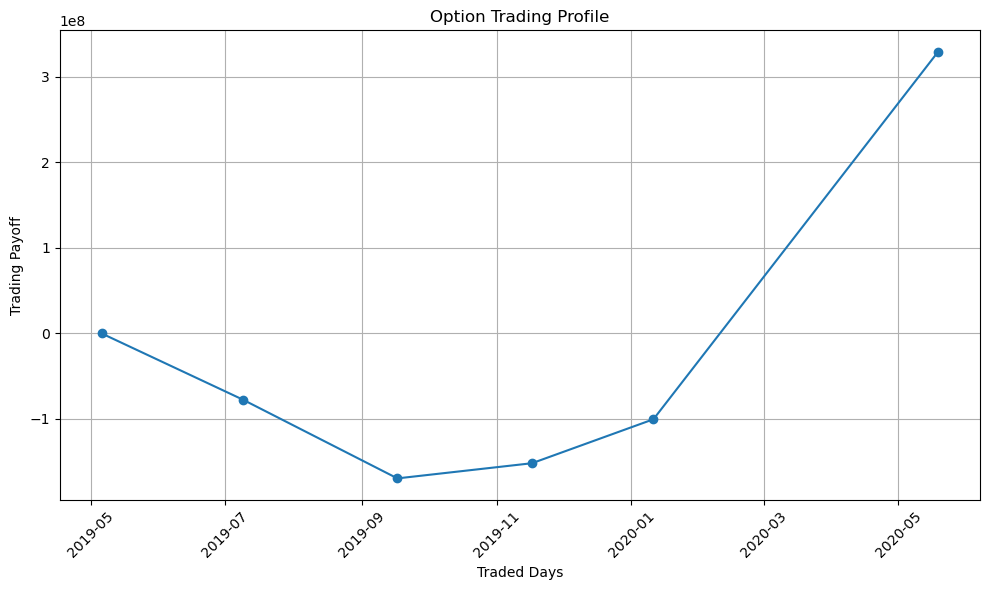

In [183]:
# Combine consecutive values with the same date
CummulativeProfit = [profit[0]]
Traded_date = np.sort(Traded_date)
new_dates = [Traded_date[0]]
for i in range(1, len(profit)):
    if Traded_date[i] == Traded_date[i - 1]:
        CummulativeProfit[-1] += profit[i]
    else:
        CummulativeProfit.append(profit[i])
        new_dates.append(Traded_date[i])

# Calculate cumulative sum
cumulative_values = [CummulativeProfit[0]]
for i in range(1, len(CummulativeProfit)):
    cumulative_values.append(cumulative_values[-1] + CummulativeProfit[i])

plt.figure(figsize=(10, 6))
plt.plot(new_dates, cumulative_values, marker='o')
plt.xlabel('Traded Days')
plt.ylabel('Trading Payoff')
plt.title('Option Trading Profile')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()